# Importing the libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
print(device)

cpu


# Define the data transforms

In [5]:
train_tf = tf.Compose([tf.Resize((224, 224)),
                       tf.RandomHorizontalFlip(p=0.5),
                       tf.ToTensor(),
                       tf.Normalize(mean=[0.5], std=[0.5])])

val_tf = tf.Compose([tf.Resize((224, 224)),
                    tf.ToTensor(),
                    tf.Normalize(mean=[0.5], std=[0.5])])

# Get the MNIST dataset

In [6]:
train_dataset = MNIST(root='./data', train=True, download=True, transform=train_tf)
test_dataset = MNIST(root='./data', train=False, download=True, transform=val_tf)

# Visualize random training samples

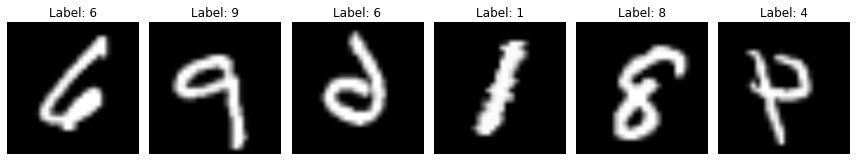

In [17]:
classes = [str(i) for i in range(10)]
indices = torch.randint(len(train_dataset), size=(6,))

plt.figure(figsize=(12, 8))
for i, idx in enumerate(indices):
    image, label = train_dataset[idx]
    image = image.squeeze()
    plt.subplot(1, 6, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {classes[label]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Get the dataloaders

In [7]:
trn_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

# Build the CNN model

In [8]:
model = nn.Sequential(nn.Conv2d(1, 64, kernel_size=3),
                      nn.ReLU(),
                      nn.MaxPool2d(2),
                      nn.Conv2d(64, 256, kernel_size=3),
                      nn.ReLU(),
                      nn.MaxPool2d(2),
                      nn.Conv2d(256, 128, kernel_size=3),
                      nn.ReLU(),
                      nn.MaxPool2d(2),
                      nn.Conv2d(128, 32, kernel_size=3),
                      nn.ReLU(),
                      nn.MaxPool2d(2),
                      nn.Flatten(),
                      nn.Linear(4608, 256),
                      nn.Linear(256, 128),
                      nn.Linear(128, 10)).to(device)

In [9]:
num_epochs = 5
lr = 1e-3
optimizer = AdamW(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()

# Train the model

In [ ]:
trn_acc, val_acc = [], []
trn_loss, val_loss = [], []

for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}/{num_epochs}')
    
    epch_trn_loss, epch_val_loss = [], []
    epch_trn_acc, epch_val_acc = [], []
    
    model.train()
    for batch in trn_loader:        
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred, y)
        _, predicted = torch.max(y_pred, 1)
        acc = (predicted == y).float().mean()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        epch_trn_loss.append(loss.item())
        epch_trn_acc.append(acc.item())
    
    model.eval()
    with torch.no_grad():
        for batch in val_loader:            
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            _, predicted = torch.max(y_pred, 1)
            acc = (predicted == y).float().mean()
            
            epch_trn_loss.append(loss.item())
            epch_trn_acc.append(acc.item())
    
    trn_acc.append(np.mean(epch_trn_acc))
    trn_loss.append(np.mean(epch_trn_loss))
    val_acc.append(np.mean(epch_val_acc))
    val_loss.append(np.mean(epch_val_loss))

# Visualize the losses

In [ ]:
import matplotlib.pyplot as plt

epochs = np.arange(num_epochs+1)

plt.plot(epochs, trn_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.title('Train and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()
plt.grid(True)
plt.show()

# Visualize the accuracies

In [ ]:
plt.plot(epochs, trn_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Val Accuracy')
plt.title('Train and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.grid(True)
plt.show()